## rock, paper, scissors classifier

In [17]:
# import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, sys, time
import ntpath

In [2]:
# read the data
data_path = "data/rps"

train_path = os.path.join(data_path, "training") 
training_scissors_path = os.path.join(train_path, "scissors") 
training_paper_path = os.path.join(train_path, "paper") 
training_rock_path = os.path.join(train_path, "rock") 
training_scissors_names = os.listdir(training_scissors_path)
training_paper_names = os.listdir(training_paper_path)
training_rock_names = os.listdir(training_rock_path)

val_path = os.path.join(data_path, "validation")
val_scissors_path = os.path.join(val_path, "scissors") 
val_paper_path = os.path.join(val_path, "paper") 
val_rock_path = os.path.join(val_path, "rock") 
val_scissors_names = os.listdir(val_scissors_path)
val_paper_names = os.listdir(val_paper_path)
val_rock_names = os.listdir(val_rock_path)

print("\033[4mTRAINING DATA\033[0m")

print("Scissors: {}".format(len(training_scissors_names)))
print("Paper: {}".format(len(training_paper_names)))
print("Rock: {}".format(len(training_rock_names)))

scissor_img = mpimg.imread(os.path.join(training_scissors_path, training_scissors_names[0]))
paper_img = mpimg.imread(os.path.join(training_paper_path, training_paper_names[0]))
rock_img  = mpimg.imread(os.path.join(training_rock_path, training_rock_names[0]))
print(f"Scissor Image Shape: {scissor_img.shape}")
print(f"Paper Image Shape: {paper_img.shape}")
print(f"Rock Image Shape: {rock_img.shape}")

## Validation Data
print("\033[4m\n\nTesting DATA\033[0m")
print("Scissors: {}".format(len(val_scissors_names)))
print("Paper: {}".format(len(val_paper_names)))
print("Rock: {}".format(len(val_rock_names)))

scissor_img = mpimg.imread(os.path.join(val_scissors_path, val_scissors_names[0]))
paper_img = mpimg.imread(os.path.join(val_paper_path, val_paper_names[0]))
rock_img  = mpimg.imread(os.path.join(val_rock_path, val_rock_names[0]))
print(f"Scissor Image Shape: {scissor_img.shape}")
print(f"Paper Image Shape: {paper_img.shape}")
print(f"Rock Image Shape: {rock_img.shape}")


TRAINING DATA
Scissors: 840
Paper: 840
Rock: 840
Scissor Image Shape: (300, 300, 4)
Paper Image Shape: (300, 300, 4)
Rock Image Shape: (300, 300, 4)


Testing DATA
Scissors: 124
Paper: 124
Rock: 124
Scissor Image Shape: (300, 300, 4)
Paper Image Shape: (300, 300, 4)
Rock Image Shape: (300, 300, 4)


In [6]:
### Draw some pictures of the training data and testing data

In [10]:
r, c = 1, 6
idx = 6
%matplotlib inline

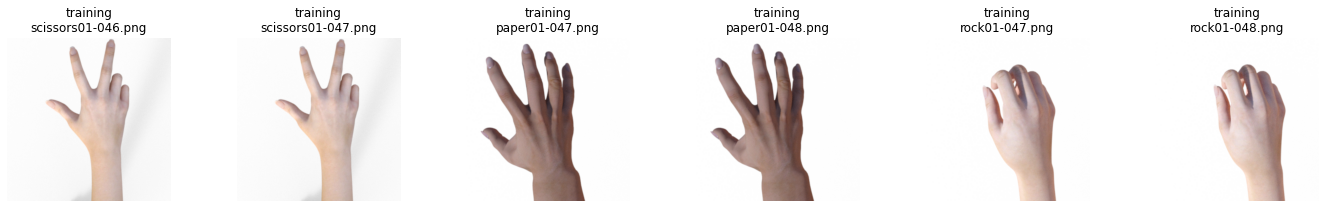

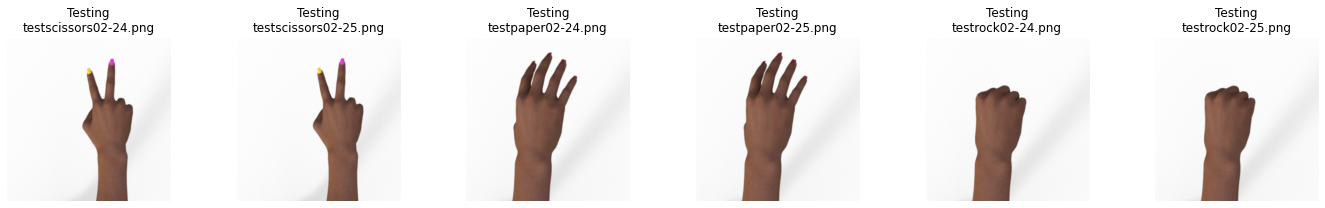

In [21]:
# set the figure size where every image will occupies 4*4 inches.
def show_imgs(path, classes_names, data_class="Train", fid=1, nrows=r, ncols=c):
    
    global idx
    plt.figure(fid)
    fig = plt.gcf()
    fig.set_size_inches(ncols*4, nrows*3)
    
    
    n = int((ncols*nrows)/3)
    scissors = [ os.path.join(path, "scissors", s) for s in classes_names[0][idx - n:idx] ]
    papers = [os.path.join(path, "paper", p) for p in classes_names[1][idx-n:idx]]
    rocks = [os.path.join(path, "rock", r) for r in classes_names[2][idx-n:idx]]
    
    idx += r*c
    
    images_paths = scissors + papers + rocks
    for img_i, img_path in enumerate(images_paths):
        sp = plt.subplot(nrows, ncols, img_i + 1)
        sp.set_title(data_class + "\n" + ntpath.basename(img_path))
        sp.axis('Off')
        img = mpimg.imread(img_path)
        plt.imshow(img)
    plt.show()
    
show_imgs(train_path, [training_scissors_names, training_paper_names, training_rock_names], "training")
show_imgs(val_path, [val_scissors_names, val_paper_names, val_rock_names], "Testing")


In [22]:
# Some Constants
BATCH_SIZE = 126
TARGET_SIZE = (150, 150)
CLASS_MODE = 'categorical'
CLASSES_NUM = 3
EPOCHS = 2
WIDTH, HEIGHT, CHANNELS = paper_img.shape
TRAIN_DATA_SIZE = len(training_paper_names) + len(training_rock_names) + len(training_scissors_names)
VAL_DATA_SIZE = len(val_paper_names) + len(val_rock_names) + len(val_scissors_names)

In [23]:
# preprocess the data
# those operations will be done using the imageGenerator class 'normalization', `reshaping`, 'etc'
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --------------------
# Flow training images in batches of 20 using train_datagen generator (data augmentation)
# --------------------
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(train_path,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode=CLASS_MODE,
                                                    target_size=TARGET_SIZE)

# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
validation_generator =  validation_datagen.flow_from_directory(val_path,
                                                         batch_size  =BATCH_SIZE,
                                                         class_mode  = CLASS_MODE,
                                                         target_size = TARGET_SIZE)


Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [24]:
# define NN model

# define the model
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(TARGET_SIZE + (3,)) ),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(CLASSES_NUM, activation='softmax')
])

# compile and fit your model
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [25]:
# fit the model.
# define callBack to stop learning when accuracy reaches 70%
class AccCallBack(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.98):
          print(f"\nReached 98% accuracy so cancelling training in epoch{epoch}")
          self.model.stop_training = True
        pass



history = model.fit(
    train_generator,
    steps_per_epoch=TRAIN_DATA_SIZE/BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=VAL_DATA_SIZE/BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[AccCallBack()],
    verbose=2)

Epoch 1/2
20/20 - 67s - loss: 1.1436 - accuracy: 0.3246 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 2/2
20/20 - 34s - loss: 1.0987 - accuracy: 0.3282 - val_loss: 1.0986 - val_accuracy: 0.3333


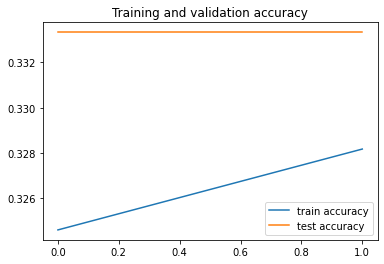

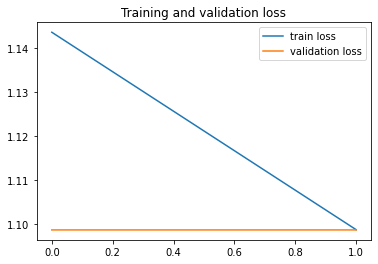

In [26]:
# Evaluating Accuracy and Loss for the Model
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label="train accuracy" )
plt.plot  ( epochs, val_acc, label="test accuracy" )
plt.title ('Training and validation accuracy')
plt.legend()
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     loss, label="train loss"  )
plt.plot  ( epochs, val_loss, label="validation loss" )
plt.title ('Training and validation loss'   )
plt.legend()

In [27]:
# save the model
model_path = "models/rps_classifier_model"

# save as tensorflow savedModel format (.pb, variables, assests)
model.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/rps_classifier_model/assets
